In [1]:
import numpy as np
import gymnasium as gym
import time
from gymnasium.spaces import Box, Discrete, MultiDiscrete, MultiBinary, Dict, Sequence
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
import os
import copy

#CWD = os.path.dirname(os.path.abspath(__file__))

In [9]:
class UnitCommitmentEnv(gym.Env):
    def __init__(self, num_units, unit_characteristics):
        super(UnitCommitmentEnv, self).__init__()

        self.num_units = num_units
        self.load_forecast = np.random.rand(np.random.randint(12, 96))*3.5 + 0.1
        self.unit_characteristics = unit_characteristics
        self.current_time = 0
        self.total_cost = 0

        #self.action_space = Discrete(3 * num_units)

        #self.action_space = MultiDiscrete(np.ones((2**self.num_units-1,), dtype=int)*2)
        #self.action_space = MultiDiscrete(np.ones((self.num_units,), dtype=int)*2)
        self.action_space = MultiBinary(self.num_units)

        #self.observation_space = Box(low=0, high=1, shape=(num_units,), dtype = int)
        self.observation_space = Dict({
            "unit_status": MultiBinary(self.num_units),
            "unit_startup_time": Box(low=-999, high = len(self.load_forecast), shape=(self.num_units,), dtype=np.float32),
            "unit_shutdown_time": Box(low=-999, high = len(self.load_forecast), shape=(self.num_units,), dtype=np.float32),
            "next_step_load": Box(low= 0.0, high =10.0, dtype = np.float32)
        })

        self.P = 0.0

        self.reset()

    def reset(self, seed = None, options = None):
        self.load_forecast = np.random.rand(np.random.randint(12, 96))*3.5 + 0.1
        self.current_time = 0
        self.total_cost = 0
        
        self.current_obs = self.observation_space.sample()

        self.current_obs["unit_status"] = np.ones((self.num_units,), dtype=np.int8) # all units online
        self.current_obs["unit_shutdown_time"] = np.copy(self.observation_space["unit_shutdown_time"].low)
        self.current_obs["unit_startup_time"] = np.copy(self.observation_space["unit_startup_time"].low)
        self.current_obs["next_step_load"] = Box(low= self.load_forecast[0], high = self.load_forecast[0], dtype = np.float32).sample()

        self.P = sum([self.unit_characteristics[id]['Pmax'] for id in range(self.num_units)])

        return self.current_obs, {}
    
    def step(self, action):
        # NOTE: Action is an array

        reward = 0.0
        for unit_id, action_type in enumerate(action):
            # Update unit status
            if action_type == 0:  # Turn off
                if self.current_obs['unit_status'][unit_id] == 1:
                    self.current_obs['unit_status'][unit_id] = 0
                    self.current_obs['unit_shutdown_time'][unit_id] = self.current_time

                    time_on = self.current_time - self.current_obs['unit_startup_time'][unit_id]
                    if time_on < self.unit_characteristics[unit_id]['min_t_up']: # Unit has been on for a time less than required. Unit can be damaged
                        reward -= 100
            elif action_type == 1:  # Turn on
                if self.current_obs['unit_status'][unit_id] == 0:
                    self.current_obs['unit_status'][unit_id] = 1
                    self.current_obs['unit_startup_time'][unit_id] = self.current_time

                    time_off = self.current_time - self.current_obs['unit_shutdown_time'][unit_id]
                    if time_off < self.unit_characteristics[unit_id]['cold_start_time']:
                        # Cost is hot start cost (unit is still hot)
                        reward -= self.unit_characteristics[unit_id]['HSC']
                        if time_off < self.unit_characteristics[unit_id]['min_t_down']:
                            # Unit has not been off for minimum time so unit could be damaged
                            reward -= 100
                    else:
                        # Unit is already cool down
                        reward -= self.unit_characteristics[unit_id]['CSC']

        # Now add the cost of all remaining units
        # for i in range(self.num_units):
        #     reward -= self.current_obs['unit_status'][i] * self.unit_characteristics[i]['fuel_cost']

        # Finally if the combinations of units cannot supply the demand, penalize
        total_supplied = 0.0
        for i in range(self.num_units):
            total_supplied += self.current_obs['unit_status'][i] * self.unit_characteristics[i]['Pmax']

        if total_supplied < self.load_forecast[self.current_time]:
            reward -= 1000
        else:
            reward += 5000

        self.P = total_supplied

        # Update time
        self.current_time += 1

        # Check if episode is done
        done = self.current_time >= len(self.load_forecast)

        if not done:
            self.current_obs["next_step_load"] = Box(low= self.load_forecast[self.current_time], high = self.load_forecast[self.current_time], dtype = np.float32).sample()

        # Get reward
        #reward = -self.total_cost

        return self.current_obs, reward, done, False, {}

In [10]:
# Example usage
num_units = 3
unit_characteristics = [
    {'Pmax': 1.0, 'Pmin': 0.10, 'Qmax': 10, 'Qmin': -10, 'a': 200, 'b': 30, 'c': 0.1, 'IHR': 10000, 'fuel_cost': 23.54, 'min_t_up': 1, 'min_t_down': 1, 'HSC': 0, 'CSC': 0, 'cold_start_time': 4},
    {'Pmax': 1.5, 'Pmin': 0.25, 'Qmax': 10, 'Qmin': -10, 'a': 800, 'b': 60, 'c': 0.7, 'IHR': 9000, 'fuel_cost': 20.34, 'min_t_up': 1, 'min_t_down': 1, 'HSC': 0, 'CSC': 0, 'cold_start_time': 5},
    {'Pmax': 1.1, 'Pmin': 0.20, 'Qmax': 10, 'Qmin': -10, 'a': 400, 'b': 50, 'c': 0.55, 'IHR': 8000, 'fuel_cost': 20.00, 'min_t_up': 1, 'min_t_down': 1, 'HSC': 0, 'CSC': 0, 'cold_start_time': 4}

]

env = UnitCommitmentEnv(num_units, unit_characteristics)
obs, _ = env.reset()
print(obs)
# Test step
action = env.action_space.sample()
current_obs = env.current_obs
print("Current obs:", current_obs)
obs, reward, done, truncated, info = env.step(action)
print("Action:", action)
print("Observation:", obs)
print("Reward:", reward)
print("Done:", done)

check_env(env)

env.reset()

OrderedDict([('next_step_load', array([0.7343011], dtype=float32)), ('unit_shutdown_time', array([-999., -999., -999.], dtype=float32)), ('unit_startup_time', array([-999., -999., -999.], dtype=float32)), ('unit_status', array([1, 1, 1], dtype=int8))])
Current obs: OrderedDict([('next_step_load', array([0.7343011], dtype=float32)), ('unit_shutdown_time', array([-999., -999., -999.], dtype=float32)), ('unit_startup_time', array([-999., -999., -999.], dtype=float32)), ('unit_status', array([1, 1, 1], dtype=int8))])
Action: [0 1 1]
Observation: OrderedDict([('next_step_load', array([2.9394321], dtype=float32)), ('unit_shutdown_time', array([   0., -999., -999.], dtype=float32)), ('unit_startup_time', array([-999., -999., -999.], dtype=float32)), ('unit_status', array([0, 1, 1], dtype=int8))])
Reward: 5000.0
Done: False


(OrderedDict([('next_step_load', array([1.0422502], dtype=float32)),
              ('unit_shutdown_time',
               array([-999., -999., -999.], dtype=float32)),
              ('unit_startup_time',
               array([-999., -999., -999.], dtype=float32)),
              ('unit_status', array([1, 1, 1], dtype=int8))]),
 {})

In [11]:
class OnStepCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [17]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)

callback = OnStepCallback(check_freq=10000, log_dir=log_dir)

# Instantiate agent
model = PPO(
    "MultiInputPolicy",
    env = env,
    verbose = 0,
    n_steps=1024,
    batch_size=64,
    gae_lambda=0.99,
    n_epochs=4,
    ent_coef=0.01
)
try:
  model.learn(total_timesteps=int(10e5), progress_bar=True, callback=callback)
except KeyboardInterrupt:
  pass

model.save("ppo_unit-commitment_sb3")

Output()

Num timesteps: 10000

Best mean reward: -inf - Last mean reward per episode: 95640.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 20000

Best mean reward: 95640.00 - Last mean reward per episode: 109630.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 30000

Best mean reward: 109630.00 - Last mean reward per episode: 106890.00

Num timesteps: 40000

Best mean reward: 109630.00 - Last mean reward per episode: 105180.00

Num timesteps: 50000

Best mean reward: 109630.00 - Last mean reward per episode: 118500.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 60000

Best mean reward: 118500.00 - Last mean reward per episode: 102780.00

Num timesteps: 70000

Best mean reward: 118500.00 - Last mean reward per episode: 98700.00

Num timesteps: 80000

Best mean reward: 118500.00 - Last mean reward per episode: 122360.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 90000

Best mean reward: 122360.00 - Last mean reward per episode: 111750.00

Num timesteps: 100000

Best mean reward: 122360.00 - Last mean reward per episode: 104930.00

Num timesteps: 110000

Best mean reward: 122360.00 - Last mean reward per episode: 118810.00

Num timesteps: 120000

Best mean reward: 122360.00 - Last mean reward per episode: 123690.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 130000

Best mean reward: 123690.00 - Last mean reward per episode: 118080.00

Num timesteps: 140000

Best mean reward: 123690.00 - Last mean reward per episode: 121670.00

Num timesteps: 150000

Best mean reward: 123690.00 - Last mean reward per episode: 120230.00

Num timesteps: 160000

Best mean reward: 123690.00 - Last mean reward per episode: 122040.00

Num timesteps: 170000

Best mean reward: 123690.00 - Last mean reward per episode: 116830.00

Num timesteps: 180000

Best mean reward: 123690.00 - Last mean reward per episode: 126660.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 190000

Best mean reward: 126660.00 - Last mean reward per episode: 132560.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 200000

Best mean reward: 132560.00 - Last mean reward per episode: 110950.00

Num timesteps: 210000

Best mean reward: 132560.00 - Last mean reward per episode: 117880.00

Num timesteps: 220000

Best mean reward: 132560.00 - Last mean reward per episode: 133340.00

Saving new best model to /tmp/gym/best_model.zip

Num timesteps: 230000

Best mean reward: 133340.00 - Last mean reward per episode: 120010.00

Num timesteps: 240000

Best mean reward: 133340.00 - Last mean reward per episode: 131420.00

Num timesteps: 250000

Best mean reward: 133340.00 - Last mean reward per episode: 132590.00

Num timesteps: 260000

Best mean reward: 133340.00 - Last mean reward per episode: 119980.00

Num timesteps: 270000

Best mean reward: 133340.00 - Last mean reward per episode: 130370.00

Num timesteps: 280000

Best mean reward: 133340.00 - Last mean reward per episode: 130820.00

Num timesteps: 290000

Best mean reward: 133340.00 - Last mean reward per episode: 122870.00

Num timesteps: 300000

Best mean reward: 133340.00 - Last mean reward per episode: 128010.00

Num timesteps: 310000

Best mean reward: 133340.00 - Last mean reward per episode: 130620.00

Num timesteps: 320000

Best mean reward: 133340.00 - Last mean reward per episode: 129220.00

Num timesteps: 330000

Best mean reward: 133340.00 - Last mean reward per episode: 128520.00

Num timesteps: 340000

Best mean reward: 133340.00 - Last mean reward per episode: 120810.00

Num timesteps: 350000

Best mean reward: 133340.00 - Last mean reward per episode: 131160.00

Num timesteps: 360000

Best mean reward: 133340.00 - Last mean reward per episode: 116610.00

Num timesteps: 370000

Best mean reward: 133340.00 - Last mean reward per episode: 132430.00

Num timesteps: 380000

Best mean reward: 133340.00 - Last mean reward per episode: 137080.00

Saving new best model to /tmp/gym/best_model.zip

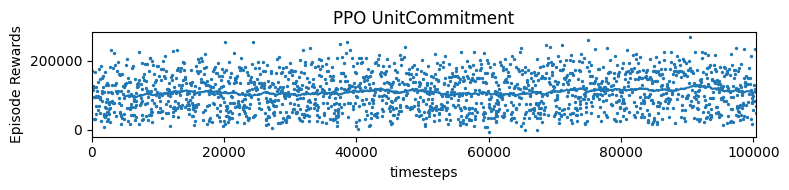

In [13]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e6, results_plotter.X_TIMESTEPS, "PPO UnitCommitment"
)

In [14]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

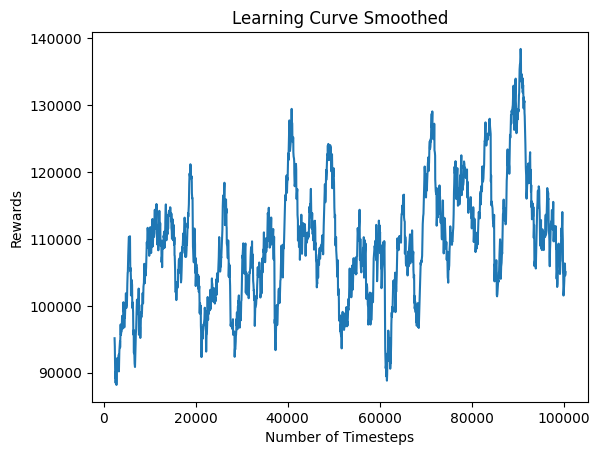

In [15]:
plot_results(log_dir)

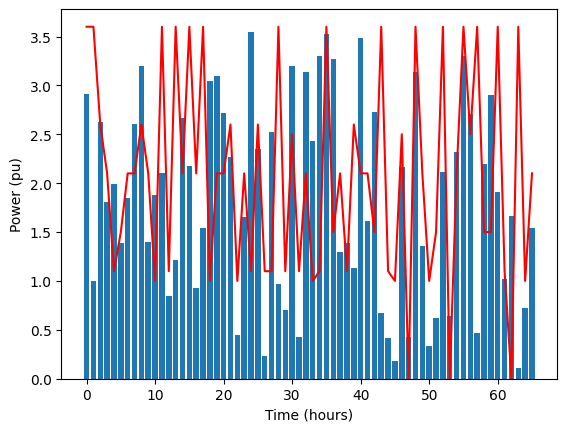

Test reward 174000.0


In [16]:
env = UnitCommitmentEnv(3, unit_characteristics)
observation, info = env.reset()
score = 0

statuses = [observation["unit_status"]]
Pgen = []
done = False
while not done:
    action, state_ = model.predict(observation)
    observation_, reward, done, truncated, info = env.step(action)

    observation = observation_
    statuses.append(observation["unit_status"])
    Pgen.append(env.P)
    score += reward


plt.figure()

x_ = np.arange(1, len(env.load_forecast)+1)
x = np.arange(len(env.load_forecast))
plt.bar(x, env.load_forecast, label = 'Load pattern')

# for i in range(len(x)-1):
#     plt.plot([x[i], x[i]], [Pgen[i], Pgen[i+1]], color='red') # vertical line
#     plt.plot([x[i+1], x[i+1]], [Pgen[i], Pgen[i+1]], color='red') # vertical line
#     plt.plot([x[i], x[i+1]], [Pgen[i], Pgen[i]], color='red')

plt.plot(x, Pgen, color='red', label = 'Generation')
plt.xlabel('Time (hours)')
plt.ylabel('Power (pu)')
plt.show()
print("Test reward", score)

